Ref. https://www.kaggle.com/meliao/shap-on-titanic-why-is-rose-alive-but-jack-not

In [1]:
# @title SHAP installation
try:
  import shap
except:
  !pip install shap

     |████████████████████████████████| 371 kB 24.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509244 sha256=06b85f0cc221932555ac2bee3f5f87fcb32d215b9bf31cd6cc420ae866179dbb
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
import shap

In [3]:
# df = pd.read_csv('/Users/guday/work/jupyter/Study-SHAP/Titanic_DataSET/train.csv')
# df.head(3)

# train = pd.read_csv('/Users/guday/work/jupyter/Study-SHAP/Titanic_DataSET/train.csv', header = 0, dtype={'Age': np.float64})
# test  = pd.read_csv('/Users/guday/work/jupyter/Study-SHAP/Titanic_DataSET/test.csv' , header = 0, dtype={'Age': np.float64})

train = pd.read_csv('/content/sample_data/Titanic/train.csv', header = 0, dtype={'Age': np.float64})
test = pd.read_csv('/content/sample_data/Titanic/test.csv', header = 0, dtype={'Age': np.float64})

full_data = [train, test]

In [4]:
print (train.info())
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Step1 -- Data cleaning and feature engineering

In [5]:
def feat_analysis(feat_name, train):
    df_survived = train[[feat_name, 'Survived']].groupby([feat_name], as_index=True).mean()
    df_count = train[[feat_name, 'Survived']].groupby([feat_name], as_index=True).count()
    df_count['Survived'] = df_count['Survived']/df_count['Survived'].sum()
    df_count.columns = ['count']

    df_plot = pd.merge(df_survived, df_count, left_index=True, right_index=True)
    df_plot = df_plot*100
#     print(df_plot)
#     plt.figure()
    df_plot.plot(kind='bar')
    plt.legend(['survival rate', 'proportion'])
    plt.xticks(rotation=0)
    plt.xlabel(df_plot.columns[0])
    plt.xlabel('')
    plt.ylabel('%')
    plt.title(feat_name)
    plt.show()

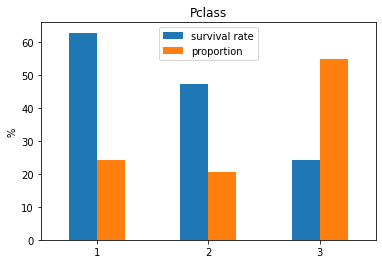

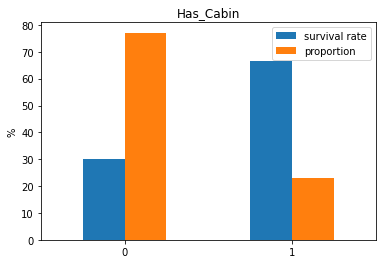

In [6]:
# Class
feat_name = 'Pclass'
feat_analysis(feat_name, train)

for dataset in full_data:
    dataset['Has_Cabin'] = (dataset['Cabin']==dataset['Cabin'])*1
    
feat_name = 'Has_Cabin'
feat_analysis(feat_name, train)

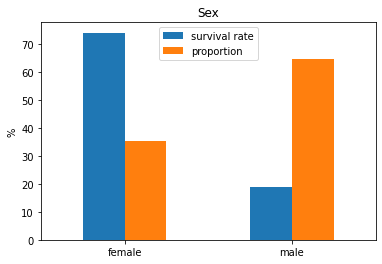

In [7]:
# Sex
for dataset in full_data:
    dataset['Sex_code'] = 1*(dataset['Sex']=='female')

    
feat_name = 'Sex'
feat_analysis(feat_name, train)

In [8]:
## Show the categories of Age and Fare
print(pd.qcut(train['Fare'].fillna(dataset['Fare'].median()), 5).unique())
print(pd.qcut(train['Age'].fillna(dataset['Age'].median()), 5).unique())

[(-0.001, 7.854], (39.688, 512.329], (7.854, 10.5], (10.5, 21.679], (21.679, 39.688]]
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] <
                                    (21.679, 39.688] < (39.688, 512.329]]
[(20.0, 27.0], (28.0, 38.0], (38.0, 80.0], (0.419, 20.0], (27.0, 28.0]]
Categories (5, interval[float64]): [(0.419, 20.0] < (20.0, 27.0] < (27.0, 28.0] < (28.0, 38.0] <
                                    (38.0, 80.0]]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

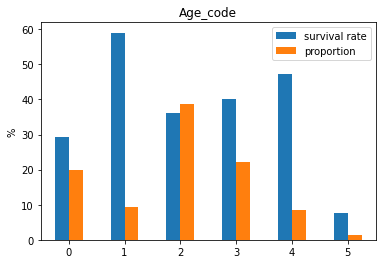

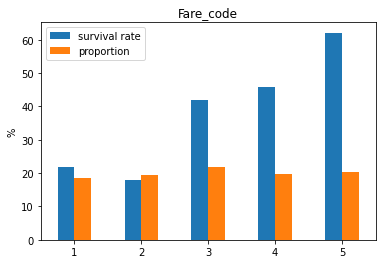

In [9]:
# Age & Fare
for dataset in full_data:
    dataset['Age'] = dataset['Age'].fillna(-10)
    dataset['Age_code'] = 0
    dataset['Age_code'].loc[(dataset['Age']>=0) & (dataset['Age']<16)] = 1
    dataset['Age_code'].loc[(dataset['Age']>=16) & (dataset['Age']<32)] = 2
    dataset['Age_code'].loc[(dataset['Age']>=32) & (dataset['Age']<48)] = 3
    dataset['Age_code'].loc[(dataset['Age']>=48) & (dataset['Age']<64)] = 4
    dataset['Age_code'].loc[dataset['Age']>=64] = 5
    
    
    dataset['Fare'] = dataset['Fare'].fillna(-10)
    dataset['Fare_code'] = 0
    dataset['Fare_code'].loc[(dataset['Fare']>=0) & (dataset['Fare']<7.85)] = 1
    dataset['Fare_code'].loc[(dataset['Fare']>=7.85) & (dataset['Fare']<10.5)] = 2
    dataset['Fare_code'].loc[(dataset['Fare']>=10.5) & (dataset['Fare']<21.67)] = 3
    dataset['Fare_code'].loc[(dataset['Fare']>=21.67) & (dataset['Fare']<39.68)] = 4
    dataset['Fare_code'].loc[dataset['Fare']>=39.68] = 5
    
feat_name = 'Age_code'
feat_analysis(feat_name, train)

feat_name = 'Fare_code'
feat_analysis(feat_name, train)

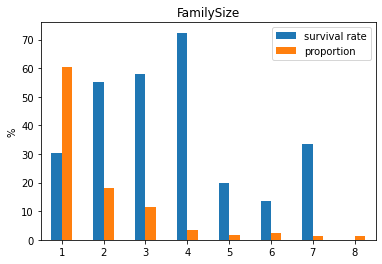

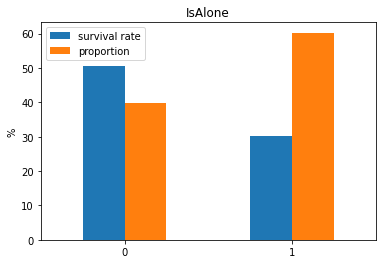

In [10]:
# SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset.loc[dataset['FamilySize']>=8, 'FamilySize'] = 8
    
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    
feat_name = 'FamilySize'
feat_analysis(feat_name, train)

feat_name = 'IsAlone'
feat_analysis(feat_name, train)

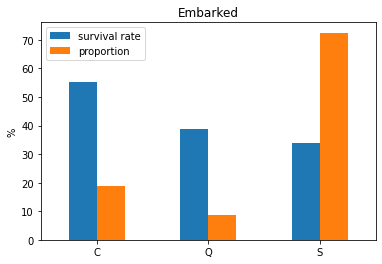

In [11]:
# Embarked port
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked_code'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

feat_name = 'Embarked'
feat_analysis(feat_name, train)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

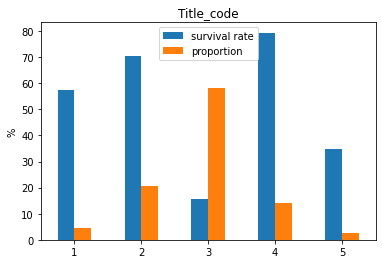

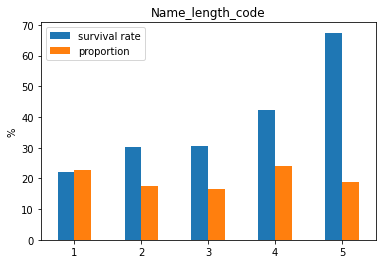

In [12]:
# Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)    
    dataset['Name_length_code'] = 0
    dataset['Name_length_code'].loc[(dataset['Name_length']>=0) & (dataset['Name_length']<20)] = 1
    dataset['Name_length_code'].loc[(dataset['Name_length']>=20) & (dataset['Name_length']<24)] = 2
    dataset['Name_length_code'].loc[(dataset['Name_length']>=24) & (dataset['Name_length']<27)] = 3
    dataset['Name_length_code'].loc[(dataset['Name_length']>=27) & (dataset['Name_length']<33)] = 4
    dataset['Name_length_code'].loc[dataset['Name_length']>=33] = 5
    
    
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Title_code'] = 0
    dataset['Title_code'].loc[dataset['Title']=='Master']=1
    dataset['Title_code'].loc[dataset['Title']=='Miss']=2
    dataset['Title_code'].loc[dataset['Title']=='Mr']=3
    dataset['Title_code'].loc[dataset['Title']=='Mrs']=4
    dataset['Title_code'].loc[dataset['Title']=='Rare']=5

    
feat_name = 'Title_code'
feat_analysis(feat_name, train)

feat_name = 'Name_length_code'
feat_analysis(feat_name, train)

# print(pd.qcut(train['Name_length'],5).unique())

In [13]:
target_name = 'Survived'
feature_list = ['Pclass', 'Sex_code', 'Age_code',  'Fare_code','Embarked_code', 
                'Name_length_code', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title_code']

## Step2 -- Fine tuning XGBoost parameters and train

In [14]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

X = train[feature_list]
y = train[target_name]

In [34]:
X.head(3)

,Pclass,Sex_code,Age_code,Fare_code,Embarked_code,Name_length_code,Has_Cabin,FamilySize,IsAlone,Title_code
0,3,0,2,1,0,2,0,2,0,3
1,1,1,3,5,1,5,1,2,0,4
2,3,1,2,2,0,2,0,1,1,2


In [35]:
y.head(3)

0    0
1    1
2    1
Name: Survived, dtype: int64

In [15]:
def hyperopt_train_test(params):
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X, y, cv=5).mean()

xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.002, 0.1, 0.002)),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 8, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.7, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(50, 600, 10, dtype=int)),
    'objective':        'reg:squarederror',
    'seed':             24
}

def objective_f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

In [16]:
trials = Trials()
# You can use increase max_evals for more iteration
best = fmin(objective_f, xgb_reg_params, algo=tpe.suggest, max_evals=50, trials=trials)
print(f'Best XGBoost:\n{space_eval(xgb_reg_params, best)}')

100%|██████████| 50/50 [00:32<00:00,  1.55it/s, best loss: -0.8316176009038981]
Best XGBoost:
{'colsample_bytree': 0.5, 'learning_rate': 0.064, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 180, 'objective': 'reg:squarederror', 'seed': 24, 'subsample': 0.7564251417542875}


In [17]:
X, y = train[feature_list], train[target_name]
xgb_reg_params = {'colsample_bytree': 0.5, 'learning_rate': 0.068, 'max_depth': 3, 
                  'min_child_weight': 3, 'n_estimators': 440, 'objective': 'reg:squarederror', 
                  'seed': 24, 'subsample': 0.8163574781326463}
pred_model = XGBRegressor(**xgb_reg_params)
# pred_model = xgb.XGBClassifier(**xgb_reg_params)

model_name = 'XGBoost'
pred_model.fit(X, y)
y_pred = pred_model.predict(X)

## Step3 -- Shap explainer

model_output = "margin" has been renamed to model_output = "raw"


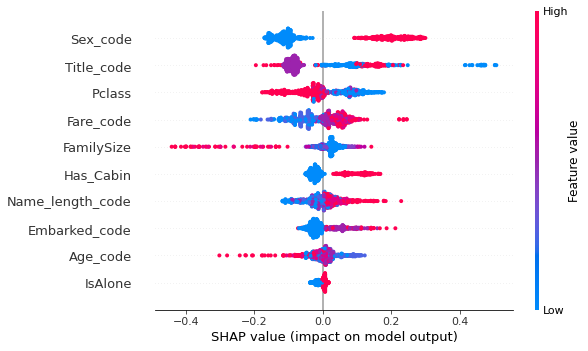

In [18]:
# margin means real contribution to the predition
explainer = shap.TreeExplainer(pred_model, model_output='margin')
shap_values = explainer.shap_values(X)
df_shap = X.copy()
df_shap.loc[:,:] = shap_values

shap.summary_plot(shap_values, X)

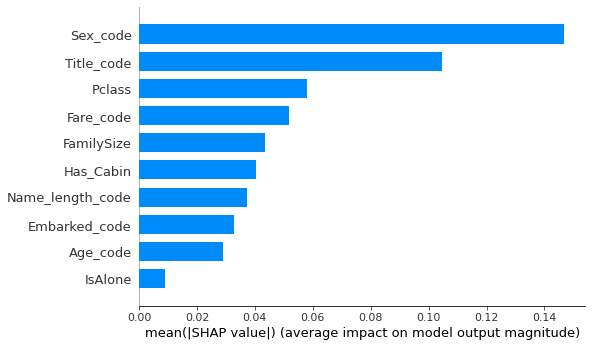

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

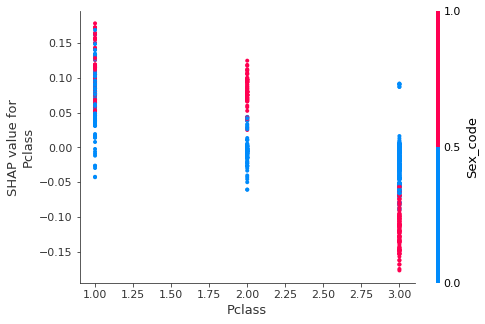

In [20]:
shap.dependence_plot("Pclass", shap_values, X, interaction_index="Sex_code")

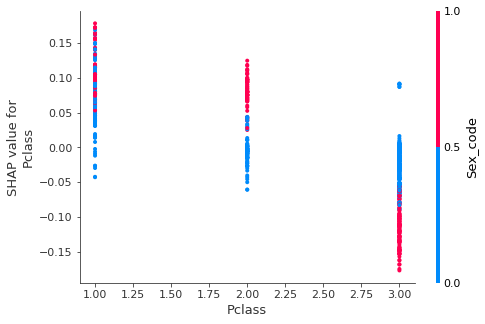

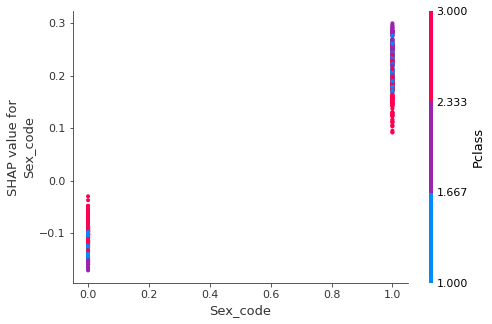

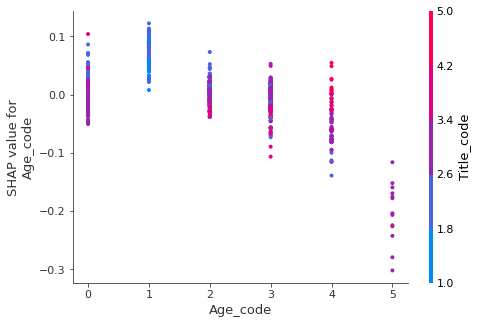

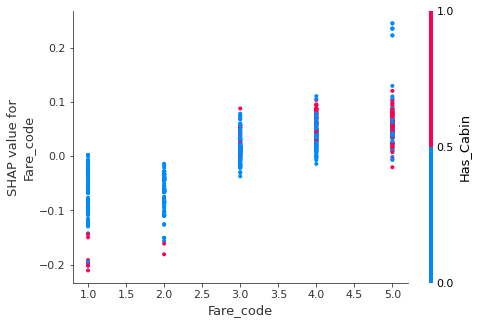

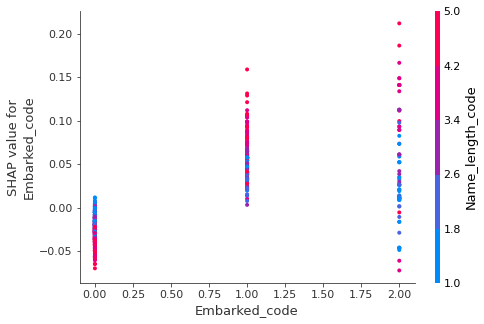

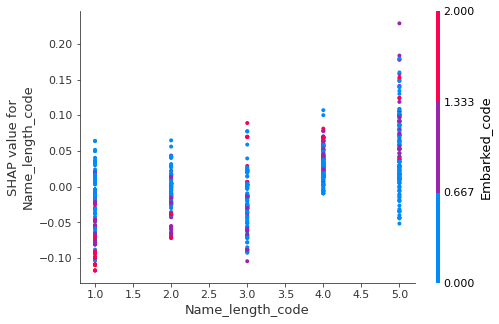

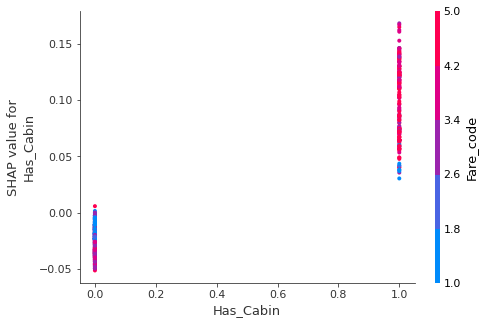

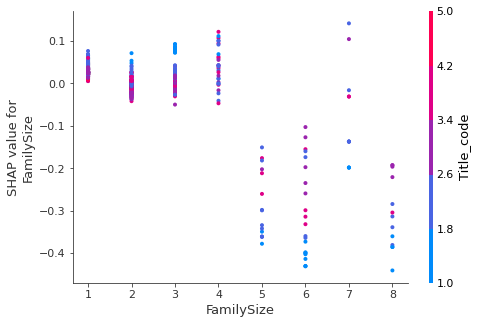

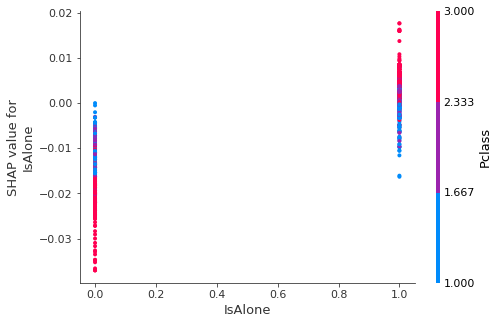

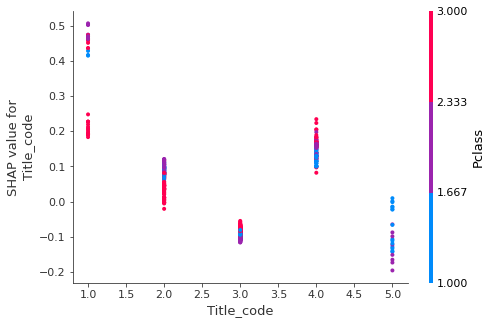

In [21]:
for feat in feature_list:
    shap.dependence_plot(feat, shap_values, X, interaction_index='auto')

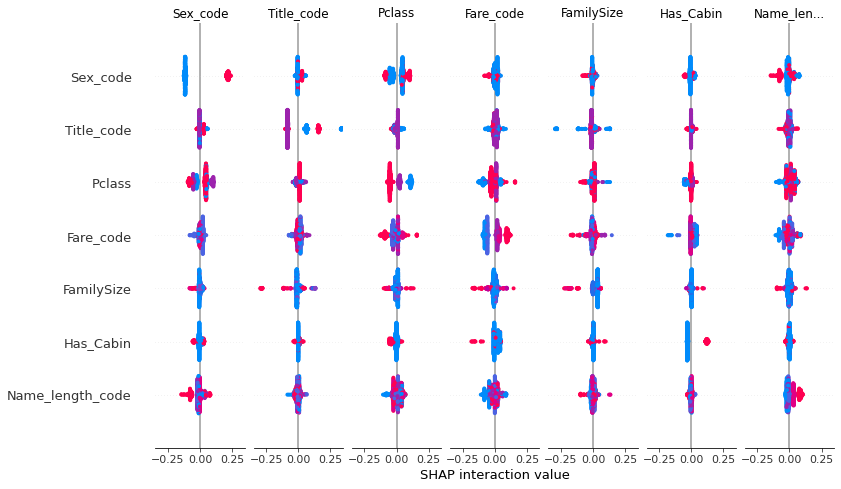

In [22]:
shap_interaction_values = shap.TreeExplainer(pred_model).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

## 3.3 Supervised clustering using shap value (hierarchical agglomerative)

In [28]:
# !pip3 install shap
import sys

print("--sys.version—-")
print(sys.version)

--sys.version—-
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [23]:
from shap.common import hclust_ordering
from sklearn.manifold import TSNE, MDS
import seaborn as sns

num_start_end = [200, 290] # Orange line position

hierarchical_order = hclust_ordering(shap_values, metric="sqeuclidean")
id_to_study = hierarchical_order[num_start_end[0]:num_start_end[1]]

plt.figure(figsize=(10,3))
plt.plot(y_pred[hierarchical_order])
plt.axvline(x=num_start_end[0], color='orangered')
plt.axvline(x=num_start_end[1], color='orangered')
plt.title(f'Prediction sorted by hierarchical similarity of SHAP values', fontsize=20)

ModuleNotFoundError: ignored

In [ ]:
shap_TSNE = TSNE(n_components=2).fit_transform(df_shap)


df_shap_Clustering = np.zeros(len(X))
df_shap_Clustering[id_to_study] = 1

for i in np.unique(df_shap_Clustering):
    plt.scatter(shap_TSNE[:,0][df_shap_Clustering==i],shap_TSNE[:,1][df_shap_Clustering==i], s=10)
plt.title('TSNE')
plt.show()

In [ ]:
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

df=X
df_scaled = StandardScaler().fit_transform(df)


df = train[feature_list]
categories = df_shap.columns

list_color = ["#0058b7", "#fc8500", "green", "red"]
list_mode = ['lines', 'lines', 'markers', 'markers']

data = []
#for i in range(len(list_name)):
trace = go.Scatterpolar(
    r=df_scaled.mean(axis=0),
    theta=categories,
    fill='toself',
    name=f'''Total ({len(df_shap_Clustering)} / 100% people): \
        {train[target_name].mean(): .2} \
        ''',
    opacity=1)
data.append(trace)

for i in range(1,2):
    trace = go.Scatterpolar(
        r=df_scaled[df_shap_Clustering==i].mean(axis=0),
        theta=categories,
        fill='toself',
#         name= f'''Type {i} ({(df_shap_Clustering==i).sum()} /{(df_shap_Clustering==i).mean()*100: .3}% people): \
#         {train[target_name][df_shap_Clustering==i].mean(): .2} \
#         ''',
        name= f'''Orange passengers ({(df_shap_Clustering==i).sum()} /{(df_shap_Clustering==i).mean()*100: .3}% people): \
        {train[target_name][df_shap_Clustering==i].mean(): .2} \
        ''',
        opacity=0.8)
    data.append(trace)


layout = {
    
}

figure = go.Figure(
    data = data,
    layout = layout
)
iplot(figure)

In [ ]:
## See orange paseengers
train.iloc[sorted(id_to_study),:13]

## 3.4 Case explanation -- why Rose is survival but Jack is dead?

In [29]:
personal_info = np.array([
    [1  , 1  , 2  , 5  , 0  , 4  , 1  , 4  , 0  , 2],
    [3  , 0  , 2  , 1  , 0  , 4  , 0  , 1  , 1  , 3],
    [1  , 0  , 2  , 5  , 0  , 4  , 1  , 4  , 0  , 3],
    [2  , 0  , 2  , 2  , 0  , 4  , 1  , 2  , 0  , 3],
                       ])

df_test = pd.DataFrame(personal_info, index=['Rose','Jack', "Fiance", "Jack_test"], columns=feature_list)
df_shap_test = df_test.copy()
df_shap_test[feature_list] = explainer.shap_values(df_test)

In [30]:
shap.initjs()
name = 'Rose'
shap.force_plot(explainer.expected_value, 
                df_shap_test.loc[name,:].values,
                df_test.loc[name,:],
               )

In [32]:
shap.initjs()
name = 'Jack'
shap.force_plot(explainer.expected_value, 
                df_shap_test.loc[name,:].values,
                df_test.loc[name,:],
               )

In [33]:
shap.initjs()
name = 'Fiance'
shap.force_plot(explainer.expected_value, 
                df_shap_test.loc[name,:].values,
                df_test.loc[name,:],
               )